In [1]:
from mesa import Agent, Model, batch_run, DataCollector
from mesa.space import MultiGrid
import random
import heapq
from sklearn.cluster import DBSCAN, KMeans

import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

import warnings
warnings.filterwarnings('ignore')

In [2]:
class Event:
    def __init__(self, time, agent, action, description=""):
        self.time = time 
        self.agent = agent
        self.action = action
        self.description = description

    def __lt__(self, other):
        return self.time < other.time 

In [3]:
class Villager(Agent):
    M_PERSONALITY = {
        "lazy": {"wake_time": 12, "sleep_time": 23, "preferred_activity": "eating"},
        "jock": {"wake_time": 8, "sleep_time": 1, "preferred_activity": "exercising"},
        "cranky": {"wake_time": 9, "sleep_time": 4, "preferred_activity": "reading"},
        "smug": {"wake_time": 7, "sleep_time": 2, "preferred_activity": "shopping"}
    }
    F_PERSONALITY = {
        "normal": {"wake_time": 6, "sleep_time": 22, "preferred_activity": "playing"},
        "peppy": {"wake_time": 10, "sleep_time": 2, "preferred_activity": "shopping"},
        "snooty": {"wake_time": 9, "sleep_time": 3, "preferred_activity": "shopping"},
        "sisterly": {"wake_time": 10, "sleep_time": 3, "preferred_activity": "reading"}
    }
    
    def __init__(self, model):
        super().__init__(model)
        # Assign random gender
        self.gender = random.choice(["male", "female"])

        # Assign random personality
        if self.gender == "male":
            self.personality = random.choice(list(self.M_PERSONALITY.keys()))
        elif self.gender == "female":
            self.personality = random.choice(list(self.F_PERSONALITY.keys()))

        self.state = self.activity()

    def get_personality(self):
        return self.M_PERSONALITY[self.personality] if self.gender == "male" else self.F_PERSONALITY[self.personality]

    def step(self):
        current_hour = self.model.hour
        personality = self.get_personality()

        if current_hour <= personality["wake_time"] and current_hour >= personality["sleep_time"]:
            self.state = "sleeping"
            print(f"Villager {self.unique_id} ({self.personality}) is sleeping.")
        else:
            self.choose_action()

    def wake_up(self):
        self.choose_action()

    def sleep(self):
        self.state = "sleeping"
    
    def walk(self):
        distance = random.randint(1,9)
        possible_moves = self.model.grid.get_neighborhood(self.pos, moore=True, include_center=False, radius=distance)
        new_position = self.random.choice(possible_moves)
        self.model.grid.move_agent(self, new_position)        

    def activity(self):
        activities = ["reading", "shopping", "exercising", "playing", "eating"]
        weights = [5, 1, 1, 1, 1]
        hobby = self.get_personality()["preferred_activity"]
            
        # villagers more likely to choose preferred activity
        current_index = activities.index(hobby)
        element = activities.pop(current_index)
        activities.insert(0, element)
            
        return random.choices(activities, weights=weights, k=1)[0]
    
    def choose_action(self):
        self.walk()
        neighbors = self.model.grid.get_neighbors(self.pos, moore=True, include_center=True, radius=0)

        activity_time = random.randint(1,3)
        next_time = self.model.current_time + activity_time

        awake_villagers = [v for v in neighbors if v.state != "sleeping" and self.unique_id != v.unique_id]

        if awake_villagers:
            activity = "socializing"
            for villager in awake_villagers:
                print(f"Time {self.model.current_time}: Villager {self.unique_id} ({self.personality}) starts {activity} with Villager {villager.unique_id}.")

        else:    
            activity = self.activity()
        
            print(f"Time {self.model.current_time}: Villager {self.unique_id} ({self.personality}) starts {activity}.")
        self.state = activity    
        self.model.schedule_event(next_time, self, self.choose_action, f"Villager {self.unique_id} finishes {activity}")
        

In [4]:
class ACModel(Model):
    def __init__(self, width, height, n, seed=None):
        super().__init__(seed=seed)
        self.grid = MultiGrid(width, height, False)
        self.current_time = 0  # Simulation time starts at 0
        self.event_queue = []  # Priority queue for events
        self.villagers = []
        self.last_logged_hour = -1

        # Create villagers
        villagers = Villager.create_agents(model=self, n=n)
        
        # Create x and y coordinates for agents
        x = self.rng.integers(0, self.grid.width, size=(n,))
        y = self.rng.integers(0, self.grid.height, size=(n,))
        
        for a, i, j in zip(villagers, x, y):
            self.grid.place_agent(a, (i, j))

            # Schedule their wake-up and sleep event
            wake_time = a.get_personality()["wake_time"]
            self.schedule_event(wake_time, a, a.wake_up, f"Villager {a.unique_id} ({a.personality}) wakes up.")

            sleep_time = a.get_personality()["sleep_time"]
            self.schedule_event(sleep_time, a, a.sleep, f"Villager {a.unique_id} ({a.personality}) goes to sleep.")

        self.villagers = villagers
        self.datacollector = DataCollector(agent_reporters={"State": "state", "Personality":"personality", 
                                                            "Hour": "current_time", "Pos": lambda a: a.pos})

    def run(self, max_time=24):
        """Run the simulation up to max_time (full day by default)"""
        self.movement = {}
        self.history = {}

        for hour in range(max_time):
            self.current_time = hour  # Step hour by hour

            # Process all events scheduled for this hour
            while self.event_queue and self.event_queue[0].time == self.current_time:
                event = heapq.heappop(self.event_queue)
                event.action()
                self.datacollector.collect(self)

            # Print villager states once per hour, even if no events occurred
            print(f"\n--- Villager States at Hour {self.current_time} ---")
            for villager in self.villagers:
                print(f"Villager {villager.unique_id} ({villager.personality}): {villager.state}")

                if villager.unique_id not in self.movement:
                    self.movement[villager.unique_id] = []
        
                self.movement[villager.unique_id].append((hour, villager.pos))
            print("-----------------------------------\n")

            self.history[hour] = {v.unique_id: (v.pos, v.state) for v in self.villagers}
            


    def schedule_event(self, time, agent, action, description=""):
        heapq.heappush(self.event_queue, Event(time, agent, action, description))

In [5]:
model = ACModel(width=10, height=10, n=10)

# Run the simulation for 24 hours
model.run(max_time=24)


--- Villager States at Hour 0 ---
Villager 1 (normal): playing
Villager 2 (smug): shopping
Villager 3 (peppy): shopping
Villager 4 (sisterly): playing
Villager 5 (cranky): shopping
Villager 6 (jock): eating
Villager 7 (smug): reading
Villager 8 (normal): reading
Villager 9 (cranky): reading
Villager 10 (lazy): reading
-----------------------------------


--- Villager States at Hour 1 ---
Villager 1 (normal): playing
Villager 2 (smug): shopping
Villager 3 (peppy): shopping
Villager 4 (sisterly): playing
Villager 5 (cranky): shopping
Villager 6 (jock): sleeping
Villager 7 (smug): reading
Villager 8 (normal): reading
Villager 9 (cranky): reading
Villager 10 (lazy): reading
-----------------------------------


--- Villager States at Hour 2 ---
Villager 1 (normal): playing
Villager 2 (smug): sleeping
Villager 3 (peppy): sleeping
Villager 4 (sisterly): playing
Villager 5 (cranky): shopping
Villager 6 (jock): sleeping
Villager 7 (smug): sleeping
Villager 8 (normal): reading
Villager 9 (cra

In [6]:
def plot_heatmap(hour):
    grid_size = (model.grid.width, model.grid.height)
    heatmap = np.empty(grid_size)  # Background values for colormap
    grid_annotations = np.full(grid_size, "", dtype=object)

    # Collect agent states at the given hour
    if hour in model.history:
        for agent_id, (pos, state) in model.history[hour].items():
            if pos:
                x, y = pos
                if grid_annotations[y, x]:  
                    grid_annotations[y, x] += f"\nV{agent_id}\n {state}"
                else:
                    grid_annotations[y, x] = f"V{agent_id}\n {state}"

    fig, ax = plt.subplots(figsize=(8, 8))
    ax = sns.heatmap(
        np.ones_like(heatmap, dtype=float),
        annot=False, fmt="", cmap="coolwarm", linewidths=0.5, cbar=False, square=True
    )

    # Overlay annotations inside cells
    for y in range(grid_size[1]):
        for x in range(grid_size[0]):
            if grid_annotations[y, x]:
                ax.text(x + 0.5, y + 0.5, grid_annotations[y, x], 
                        ha='center', va='center', fontsize=9, color='white')

    ax.set_title(f"Villager Locations and States | {hour}:00")
    plt.show()

# Interactive slider
hour_slider = widgets.IntSlider(min=0, max=23, step=1, value=0, description="Hour")
interactive_plot = widgets.interactive(plot_heatmap, hour=hour_slider)

display(interactive_plot)

interactive(children=(IntSlider(value=0, description='Hour', max=23), Output()), _dom_classes=('widget-interac…

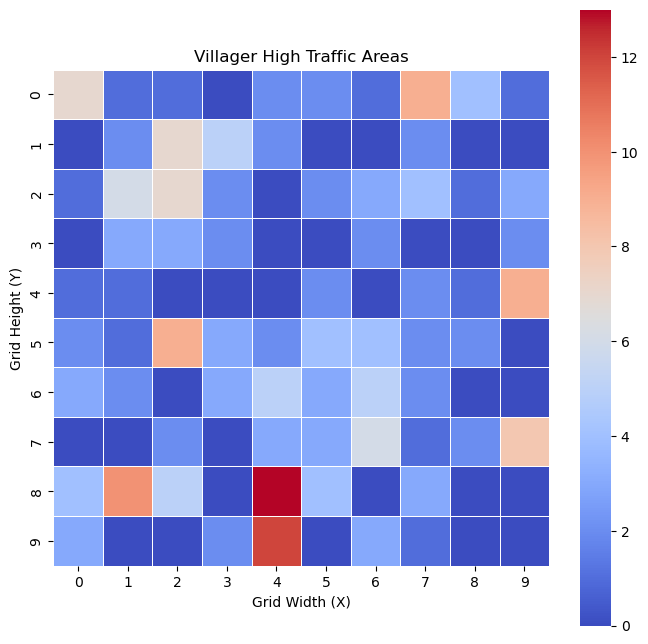

In [7]:
# Initialize movement tracking grid (same size as the model's grid)
movement_heatmap = np.zeros((model.grid.height, model.grid.width))

# Loop through recorded history and count visits per cell
for hour, data in model.history.items():
    for agent_id, (pos, state) in data.items():
        if pos:
            x, y = pos
            movement_heatmap[y, x] += 1  # Increment visit count

# Plot the heatmap
plt.figure(figsize=(8, 8))
ax = sns.heatmap(movement_heatmap, cmap="coolwarm", linewidths=0.5, square=True)

plt.title("Villager High Traffic Areas")
plt.xlabel("Grid Width (X)")
plt.ylabel("Grid Height (Y)")
plt.show()

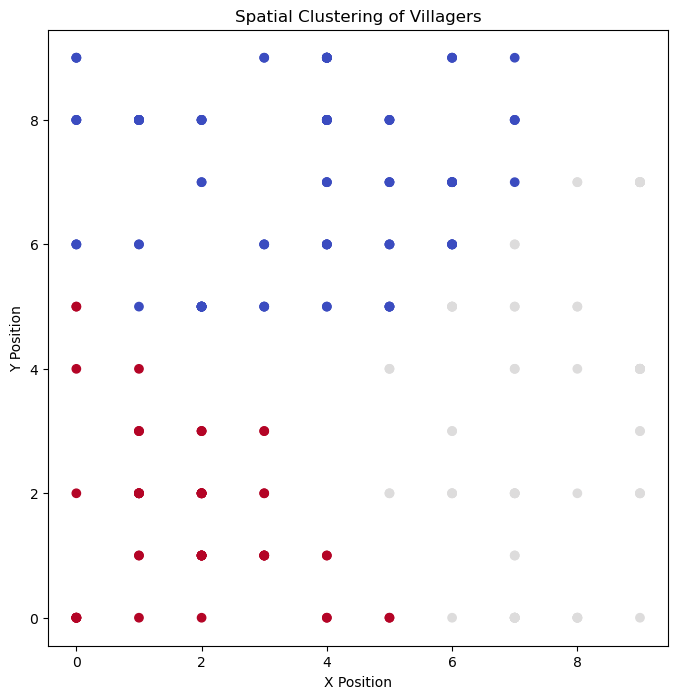

In [8]:
def spatial_cluster_analysis():
    positions = []  # Collect agent positions

    for hour, events in model.history.items():
        for agent_id, (pos, state) in events.items():
            if pos:
                positions.append(pos)

    positions = np.array(positions)

    # Apply K-Means Clustering (Adjust `n_clusters` as needed)
    n_clusters = 3  # Adjust based on data
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    labels = kmeans.fit_predict(positions)

    # Scatter plot of agent positions colored by cluster
    plt.figure(figsize=(8, 8))
    plt.scatter(positions[:, 0], positions[:, 1], c=labels, cmap="coolwarm")
    plt.title("Spatial Clustering of Villagers")
    plt.xlabel("X Position")
    plt.ylabel("Y Position")
    plt.show()

# Run spatial clustering function
spatial_cluster_analysis()

In [9]:
def cluster_villager_positions(history):
    cluster_history = {}  # Dictionary to store cluster assignments per hour

    for hour, positions in history.items():
        pos_array = np.array([pos for _, (pos, _) in positions.items() if pos])  # Extract positions

        if len(pos_array) > 0:
            clustering = DBSCAN(eps=1.5, min_samples=2).fit(pos_array)  # Adjust parameters as needed
            labels = clustering.labels_

            # Assign clusters to villagers
            hour_clusters = {villager_id: labels[i] for i, (villager_id, (pos, _)) in enumerate(positions.items()) if pos}
            cluster_history[hour] = hour_clusters

    return cluster_history

# Run clustering on movement history
cluster_assignments = cluster_villager_positions(model.history)

def track_cluster_changes(cluster_assignments):
    cluster_movements = {villager_id: [] for villager_id in model.movement.keys()}

    for hour in sorted(cluster_assignments.keys()):
        for villager_id, cluster in cluster_assignments[hour].items():
            if cluster_movements[villager_id]:  # If there's a previous cluster assignment
                last_cluster = cluster_movements[villager_id][-1][1]
                if last_cluster != cluster:  # If cluster changed
                    cluster_movements[villager_id].append((hour, cluster))
            else:
                cluster_movements[villager_id].append((hour, cluster))

    return cluster_movements

villager_cluster_movements = track_cluster_changes(cluster_assignments)

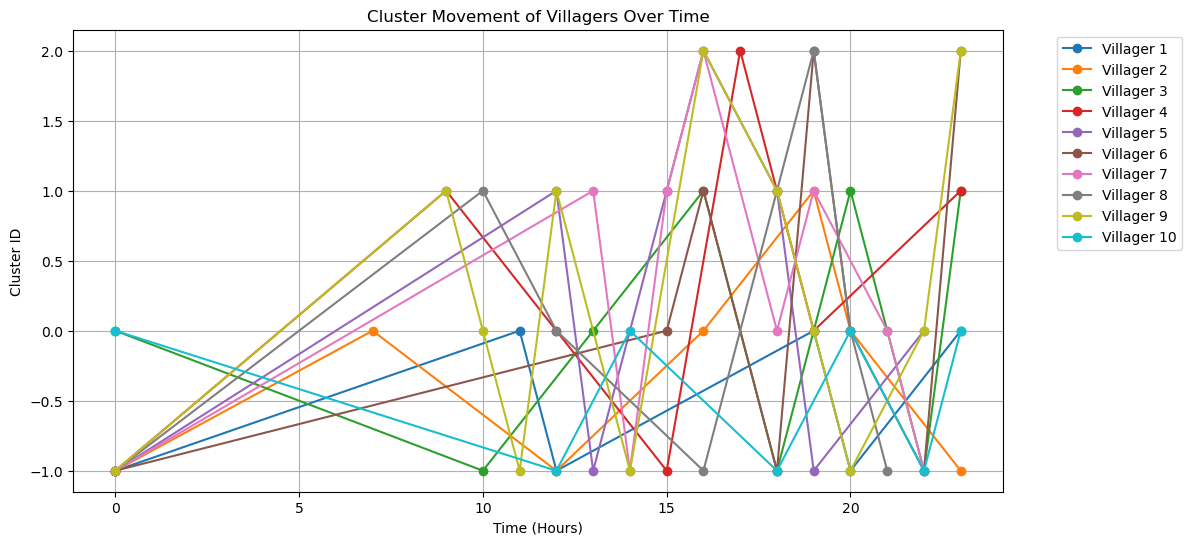

In [10]:
def plot_all_villager_movements(cluster_movements, selected_villagers=None):
    plt.figure(figsize=(12, 6))

    for villager_id, movements in cluster_movements.items():
        if selected_villagers and villager_id not in selected_villagers:
            continue  # Skip villagers not in the selection

        times, clusters = zip(*movements)
        plt.plot(times, clusters, marker="o", linestyle="-", label=f"Villager {villager_id}")

    plt.xlabel("Time (Hours)")
    plt.ylabel("Cluster ID")
    plt.title("Cluster Movement of Villagers Over Time")
    plt.legend(loc="upper right", bbox_to_anchor=(1.2, 1))
    plt.grid()
    plt.show()

# Plot movements for all villagers
plot_all_villager_movements(cluster_movements=villager_cluster_movements)

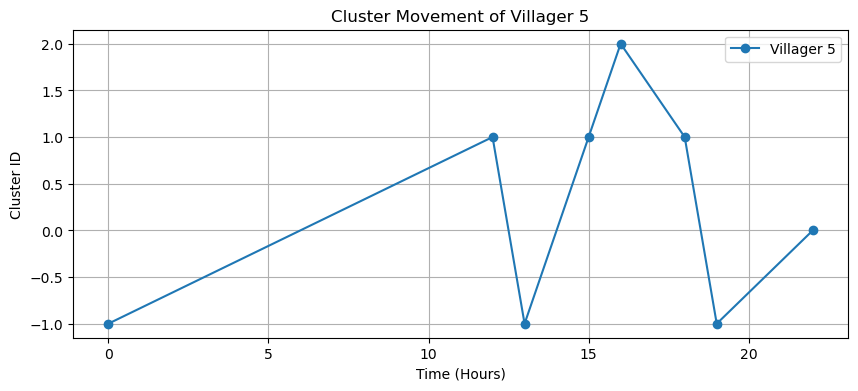

In [11]:
def plot_cluster_movement(villager_id, cluster_movements):
    times, clusters = zip(*cluster_movements[villager_id])
    
    plt.figure(figsize=(10, 4))
    plt.plot(times, clusters, marker="o", linestyle="-", label=f"Villager {villager_id}")
    
    plt.xlabel("Time (Hours)")
    plt.ylabel("Cluster ID")
    plt.title(f"Cluster Movement of Villager {villager_id}")
    plt.legend()
    plt.grid()
    plt.show()

# Plot movement for a specific villager
plot_cluster_movement(villager_id=5, cluster_movements=villager_cluster_movements)